## Grad Project Prototype

Number recognition using MLP running on the duckiebot 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

In [4]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


In [5]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

In [6]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [8]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [9]:
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [10]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [11]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [12]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=1)

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))
        h_1 = F.dropout(h_1, p=0.1)
        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))
        h_2 = F.dropout(h_2, p=0.1)
        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return y_pred, h_2

In [14]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


In [16]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

In [17]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [18]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
class NP_model():
    # Only supports MLP linear models
    def __init__(self, model_weight):
        self.weights = model_weight

    def show_dims(self):
        for key, value in self.weights.items():
            print(key, value.shape)

    def predict(self, x):
        temp = x
        for key, value in self.weights.items():
            if "weight" in key:
                temp = np.matmul(temp, value.transpose())
            elif "bias" in key:
                temp = temp + value
                temp = np.maximum(temp, 0)
        return temp

In [21]:


# evaluate using numpy weights only
def np_evaluate(np_model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

        x = x.resize(x.shape[0], 28 * 28).numpy()
        y_pred = np_model.predict(x)
        y_pred = torch.tensor(y_pred)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Export the weights as a numpy, it only supports linear layers

In [23]:
def export_weights(model, filename):
    weight_dict = {}
    for name, param in model.state_dict().items():
        weight_dict[name] = param.cpu().numpy()

    np.save(filename, weight_dict)

def import_weights(model, filename):
    """ Will return a dict of numpy arrays of weights that should be in process order """
    weight_dict = np.load(filename, allow_pickle=True).item()
    return weight_dict

In [24]:
export_weights(model, 'model_weights.npy')

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        export_weights(model, 'model_weights.npy')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [24]:
np_weights = import_weights(model, 'model_weights.npy')
np_model = NP_model(np_weights)
test_loss, test_acc = np_evaluate(np_model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/10000 [00:00<?, ?it/s]

/home/jihoon/.local/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Test Loss: 0.066 | Test Acc: 97.99%


In [28]:
def get_predictions(np_model, iterator, device):


    images = []
    labels = []
    probs = []


    for (x, y) in iterator:
        x_pre = x
        x = x.resize(x.shape[0], 28 * 28).numpy()

        y_pred = np_model.predict(x)
        y_pred = torch.tensor(y_pred)

        y_prob = F.softmax(y_pred, dim=-1)

        images.append(x_pre.cpu())
        labels.append(y.cpu())
        probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs



In [29]:
images, labels, probs = get_predictions(np_model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

/home/jihoon/.local/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [30]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

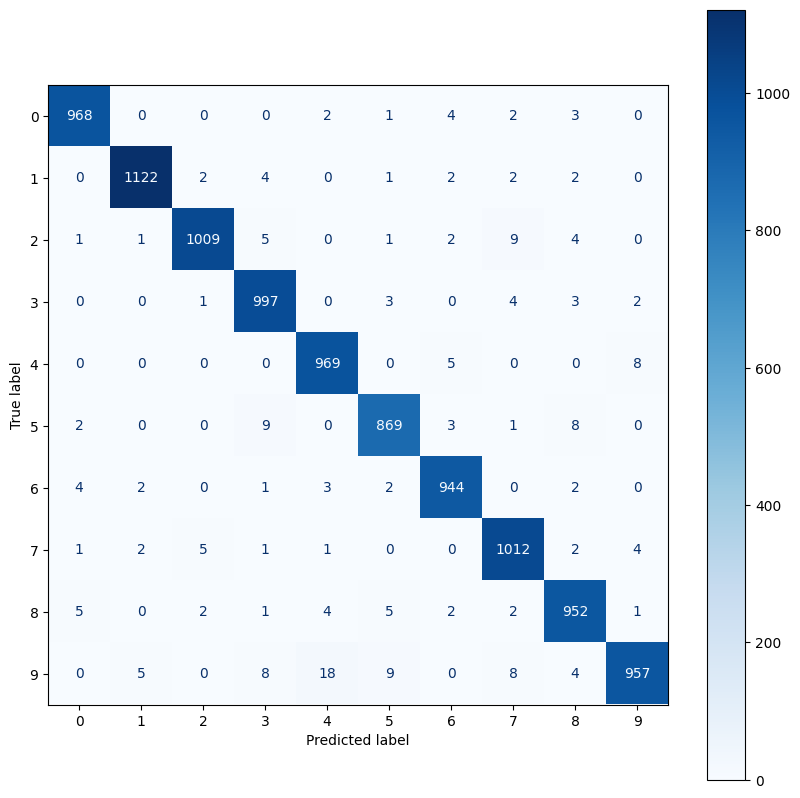

In [31]:
plot_confusion_matrix(labels, pred_labels)